***Clustering Pipeline Bert***

Imports

In [1]:
from datasets import load_dataset, concatenate_datasets
import torch
import numpy as np
from tqdm.auto import tqdm


/Users/leosteiner/Desktop/BT/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Model + Tokenizer

In [2]:
model_path = "./bert-finetuned"
from transformers import (BertTokenizerFast,BertForSequenceClassification)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

Load Dataset

In [3]:
# Load dataset
dataset = load_dataset('imdb')
train_data = dataset["train"]
test_data = dataset["test"]


Core Grad-L2 saliency for a single example
The goal of this function is:

For each token in the input, compute a saliency score that measures how much that token influenced the model’s output for some class (e.g., the predicted label).

The method used:
1. Convert input_ids → embedding vectors (word_embeds).
2. Treat those embeddings as a leaf tensor with requires_grad=True, so we can compute gradients w.r.t. them.
3. Run a forward pass with inputs_embeds=word_embeds instead of input_ids.
4. Take the logit (score) of the class we care about.
5. Call backward() to get ∂score/∂embedding for each token.
6. Compute a norm over the embedding dimension to get one scalar importance per token.
7. Convert everything to CPU / numpy and map back to token strings.

In [4]:
def grad_l2_saliency(
    text: str,
    model,
    tokenizer,
    device,
    target_class: int | None = None,
    max_length: int = 512
):
    """
    Compute Grad-L2 saliency for one input text.

    Returns:
        tokens: list[str]          # wordpiece tokens incl. special tokens
        saliency: np.ndarray       # shape (seq_len,)
        input_ids: np.ndarray      # token ids (same length as saliency)
    """
    model.eval()

    # 1) Tokenize
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length
    )
    input_ids = enc["input_ids"].to(device)           # [1, L] L = sequence length
    attention_mask = enc["attention_mask"].to(device) # [1, L]
    token_type_ids = enc.get("token_type_ids")
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    # 2) Get word embeddings and make them a leaf tensor with grad
    with torch.no_grad():
        word_embeds = model.bert.embeddings.word_embeddings(input_ids)
    word_embeds = word_embeds.detach().requires_grad_(True)  # [1, L, H]

    # 3) Forward pass using inputs_embeds so we can backprop to embeddings
    model.zero_grad()
    outputs = model(
        inputs_embeds=word_embeds, #pass embeddings instead of input_ids
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    logits = outputs.logits  # [1, num_labels]

    # 4) Choose the logit to explain: pick predicted label by default
    if target_class is None:
        target_class = logits.argmax(dim=-1).item()  # predicted label

    # using the predicted class as scalar for autograd
    score = logits[0, target_class] # standard tensor indexing: tensor[row_index, column_index]

    # 5) Backward: d score / d word_embeds # computes gradients of score with respect to all tensors that have requires_grad=True in the computation graph.
    score.backward()

    grads = word_embeds.grad  # [1, L, H] store gradient 

    # 6) L2 norm over hidden dimension -> one score per token
    saliency = torch.norm(grads, p=2, dim=-1).squeeze(0)  # [1,L,H ] -> [1,L] -> [L] collapsing H

    # 7) Move to CPU / numpy
    saliency = saliency.detach().cpu().numpy()
    input_ids_cpu = input_ids.squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids_cpu)

    return tokens, saliency, input_ids_cpu


In [5]:
# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# move to device
model.to(device)

#eval mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Simple bar plot over tokens

Example 0
Predicted label: 0
I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it's 

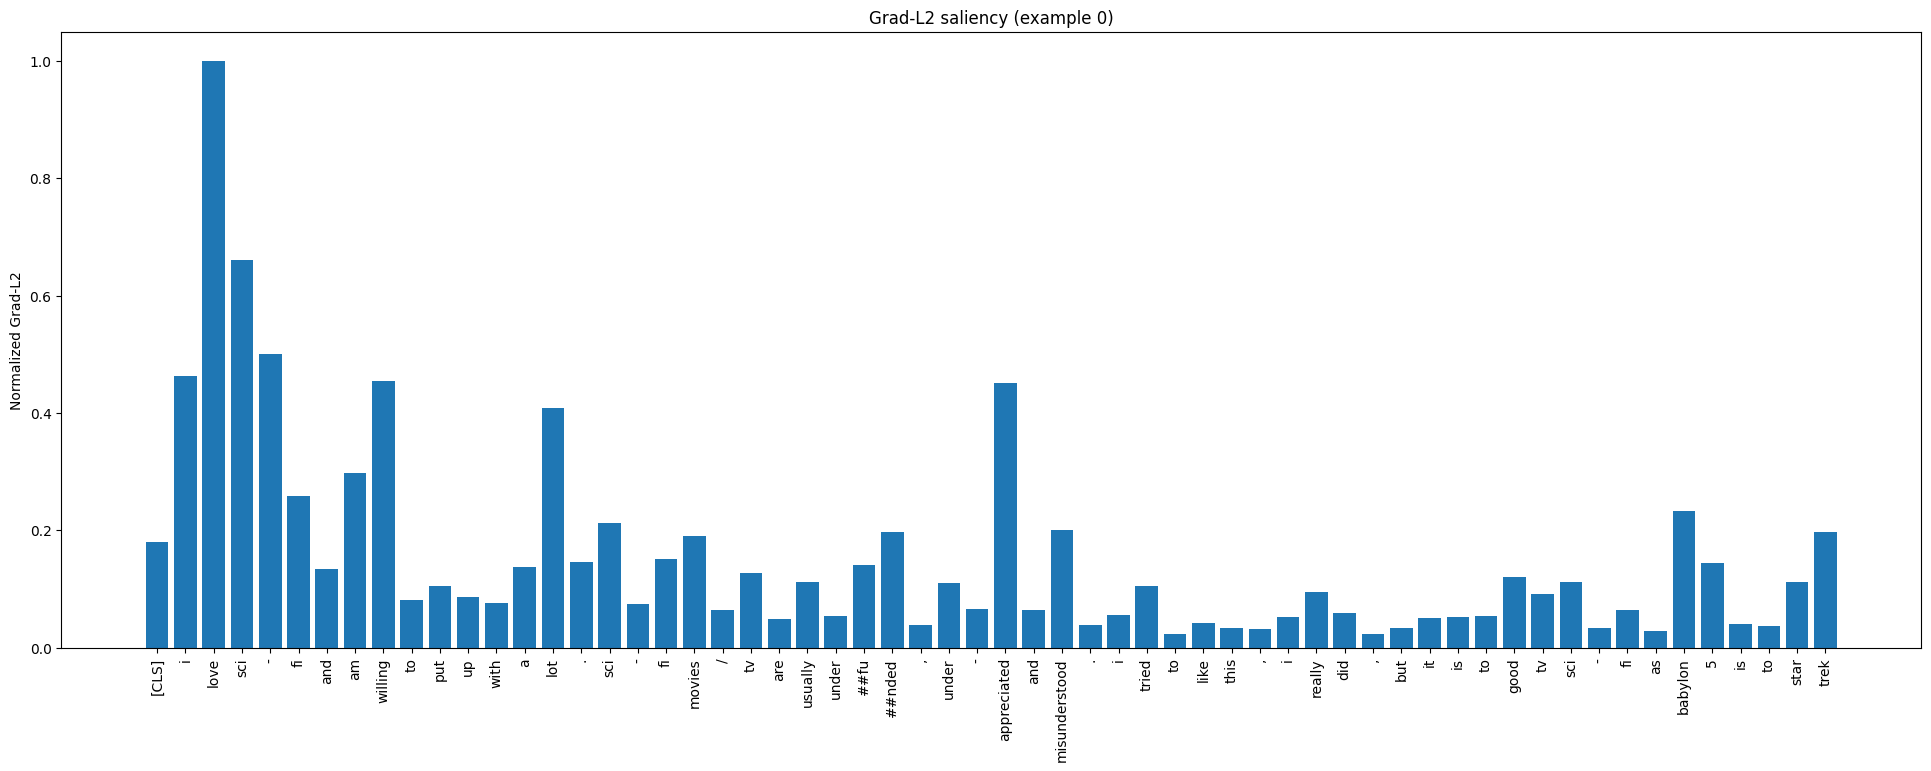

In [6]:
import torch
import matplotlib.pyplot as plt

def plot_token_saliency(tokens, saliency, title=None, max_tokens=60):
    tokens = tokens[:max_tokens]
    saliency = saliency[:max_tokens]
    sal_norm = saliency / (saliency.max() + 1e-12)

    plt.figure(figsize=(0.4 * len(tokens), 8))
    plt.bar(range(len(tokens)), sal_norm)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.ylabel("Normalized Grad-L2")
    if title is not None:
        plt.title(title)
    # plt.tight_layout()
    plt.show()


def inspect_example(idx):
    text = test_data[idx]["text"]
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        logits = model(**enc).logits
        pred = logits.argmax(-1).item()

    tokens, sal, ids = grad_l2_saliency(text, model, tokenizer, device)

    print(f"Example {idx}")
    print(f"Predicted label: {pred}")
    print("=" * 80)
    print(text[:1000], "..." if len(text) > 1000 else "")
    print("=" * 80)

    plot_token_saliency(tokens, sal, title=f"Grad-L2 saliency (example {idx})")


# try a few indices
inspect_example(0)


### Color coded text ###

In [7]:
from matplotlib import colors as mcolors
from IPython.display import HTML, display


def html_colorize(tokens, saliency, max_tokens=200):
    tokens = tokens[:max_tokens]
    saliency = saliency[:max_tokens]
    sal_norm = saliency / (saliency.max() + 1e-12) # use 1e-12 to prevent zero division error

    cmap = plt.cm.cividis  # civids works pretty well as colormap
    html_tokens = []
    for tok, s in zip(tokens, sal_norm):
        rgba = cmap(s)
        color = mcolors.to_hex(rgba)
        html_tokens.append(
            f'<span style="background-color:{color}; padding:2px; margin:1px;">{tok}</span>'
        )
    html = "<div style='font-family: monospace; line-height: 1.7;'>" + " ".join(html_tokens) + "</div>"
    display(HTML(html))


In [8]:
# Single IMDB review for testing
text = test_data[0]["text"]     
tokens, sal, ids = grad_l2_saliency(text, model, tokenizer, device)
html_colorize(tokens, sal)


### Grad-L2 for larger vocab ###

Aggregating token-level salience into a fixed-length, interpretable vector so we can analyze the dataset and model in bulk, rather than inspecting individual examples manually.

1. Initialize a vocabulary-sized zero vector.
2. Fill each token’s vocab position with its max absolute salience.
3. Identify the top-k highest salience entries.
4. Zero out all other entries.
5. Return the sparse salience vector.

In [9]:
def saliency_to_vocab_vector(input_ids, saliency, vocab_size, top_k=5):
    """
    Implements S1 from the paper: a |V|-dim vector with the
    max |saliency| per vocab item, zeroed except for top-k entries.
    """
    r = np.zeros(vocab_size, dtype=np.float32) #expecting vocab size of bert tokenzier

    for tok_id, s in zip(input_ids, saliency):
        tok_id = int(tok_id)
        r[tok_id] = max(r[tok_id], abs(float(s))) # get max saliency value

    if top_k is not None and top_k < vocab_size:
        # Keep only top-k entries, zero out the rest
        if np.count_nonzero(r) > top_k: # count how many positoons in r are not zero
            top_idx = np.argpartition(r, -top_k)[-top_k:] # Find the indices of the k largest values in r, argsort begin nlogn efficient
            mask = np.zeros_like(r)
            mask[top_idx] = r[top_idx]
            r = mask

    return r

# vocab_size = tokenizer.vocab_size
# tokens, sal, ids 

# r = saliency_to_vocab_vector(ids, sal, vocab_size)
# r[0]

**Build the Vocab**

This function converts many text examples into their salience-fingerprints (S1 vectors), stacks those into a matrix, normalizes them, and returns both the matrix and the original texts.

<pre>
          column dimension → |V| (the r vector)
        ┌──────────────────────────────────────────────┐
 row 1  │ r(1)[0]   r(1)[1]   r(1)[2]   ...   r(1)[V-1]│
 row 2  │ r(2)[0]   r(2)[1]   r(2)[2]   ...   r(2)[V-1]│
   .    │    .         .         .              .      │
 row N  │ r(N)[0]   r(N)[1]   r(N)[2]   ...   r(N)[V-1]│
        └──────────────────────────────────────────────┘
             ↑
             vocabulary-dimension (S1 vector)***
<pre>

In [10]:
from tqdm.auto import tqdm

def build_salience_vocab_matrix(dataset, model, tokenizer, device, 
                                split="test", n_examples=2500, top_k=5, max_length=512):
    """
    dataset: HF datasets.DatasetDict with 'train'/'test'
    Returns:
        R_vocab: np.ndarray [N, |V|]
        texts: list[str]
    """
    ds = dataset[split] # corresponding split
    n = min(n_examples, len(ds)) # small datasets
    vocab_size = tokenizer.vocab_size # get vocab size

    R_rows = []
    texts = []

    for i in tqdm(range(n)):
        text = ds[i]["text"]
        tokens, sal, ids = grad_l2_saliency( # get saliency<
            text, model, tokenizer, device, max_length=max_length
        ) 
        r = saliency_to_vocab_vector(ids, sal, vocab_size, top_k=top_k)
        R_rows.append(r)
        texts.append(text)

    R_vocab = np.stack(R_rows, axis=0)  # [N, |V|]

    # Row-wise L2 normalization, as in the paper.
    norms = np.linalg.norm(R_vocab, axis=1, keepdims=True) + 1e-12 # normalize rows
    R_vocab = R_vocab / norms # R_vocab[i, j] / norms[i, 0]

    return R_vocab, texts

In [11]:
R_vocab, texts = build_salience_vocab_matrix(
    dataset, model, tokenizer, device,
    split="test", n_examples=2500, top_k=5
)


100%|██████████| 2500/2500 [03:16<00:00, 12.70it/s]


Clustering
Background:
1. Shortcut words cannot be detected by clustering tokens directly; instead, shortcut behavior emerges when sentences consistently rely on the same small subset of vocabulary items for model decisions.
2. Each sentence is converted into a high-dimensional salience vector (an S1 vector), where the top-k most influential vocabulary tokens for that sentence are encoded as non-zero dimensions; thus, every row in R_vocab represents the model’s “reasoning pattern” for one example.
3. When many sentences share the same shortcut cues—for example numeric rating tokens like “10”, “/”, “1” or toxic words like “idiot”, “moron”—their salience vectors activate the same vocabulary dimensions, making these rows very similar in high-dimensional space.
4. K-Means clustering operates on these rows (not on individual tokens), grouping together examples that exhibit similar salience patterns, thereby identifying collections of sentences the model handles in the same shortcut-driven way.
5. Each cluster’s centroid, computed as the average of all salience vectors in that group, exposes the shortcut vocabulary items because the centroid has high values precisely on the vocabulary dimensions that were frequently salient among the cluster’s examples.
6. Interpreting these centroid peaks reveals the shortcut words or token patterns—such as rating digits, profanity, or metadata jargon—that the model relied on to classify the examples in that cluster.

In [12]:
from sklearn.cluster import KMeans

def cluster_salience(R_vocab, n_clusters=5, random_state=0):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_ids = kmeans.fit_predict(R_vocab)
    return cluster_ids, kmeans


In [13]:
cluster_ids, kmeans = cluster_salience(R_vocab, n_clusters=5)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


t-Distributed Stochastic Neighbor Embedding

In [14]:
from sklearn.manifold import TSNE

def plot_tsne(R_vocab, cluster_ids, sample_size=2000):
    # Optionally subsample to keep t-SNE fast
    n = min(sample_size, R_vocab.shape[0])
    R_sub = R_vocab[:n]
    c_sub = cluster_ids[:n]

    tsne = TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        perplexity=30,
        random_state=0,
    )
    coords = tsne.fit_transform(R_sub)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=c_sub, s=8, cmap="tab10")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("t-SNE of Grad-L2 salience vocab representations (IMDB)")
    plt.tight_layout()
    plt.show()


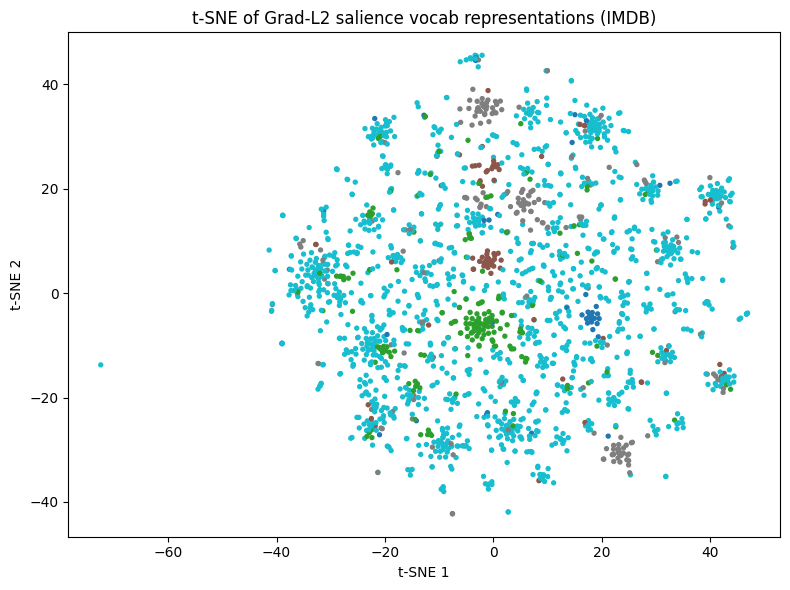

In [15]:
plot_tsne(R_vocab, cluster_ids, sample_size=2000)


In [16]:
# TODO: use only top k tokens instead of whole text

### Now lets inspect curated samples and not just the first n-samples of a set ###

Run predictions for set

In [17]:
import torch
from torch.utils.data import DataLoader

def predict_labels(dataset_split, model, tokenizer, device, batch_size=32, max_length=512):
    model.eval()
    loader = DataLoader(dataset_split, batch_size=batch_size, shuffle=False)

    all_preds = []
    with torch.no_grad():
        for batch in loader:
            texts = batch["text"]
            enc = tokenizer(
                list(texts),
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=max_length,
            ).to(device)

            logits = model(**enc).logits  # [B, 2]
            preds = logits.argmax(dim=-1).cpu()
            all_preds.extend(preds.tolist())

    return all_preds


In [18]:
test_preds = predict_labels(test_data, model, tokenizer, device)


In [19]:
import numpy as np
from tqdm.auto import tqdm

def build_salience_vocab_matrix_from_indices(
    dataset_split,
    indices,
    model,
    tokenizer,
    device,
    top_k=5,
    max_length=512,
):
    vocab_size = tokenizer.vocab_size
    R_rows = []
    texts = []

    for idx in tqdm(indices):
        text = dataset_split[idx]["text"]
        tokens, sal, ids = grad_l2_saliency(
            text, model, tokenizer, device, max_length=max_length
        )
        r = saliency_to_vocab_vector(ids, sal, vocab_size, top_k=top_k)
        R_rows.append(r)
        texts.append(text)

    R_vocab = np.stack(R_rows, axis=0)
    # row-wise L2 normalization as in the paper
    norms = np.linalg.norm(R_vocab, axis=1, keepdims=True) + 1e-12
    R_vocab = R_vocab / norms
    return R_vocab, texts

# select indices of negatively predicted examples
neg_indices = [i for i, p in enumerate(test_preds) if p == 0]  
len(neg_indices)

# sample 2500 of them (or fewer if you have less)
np.random.seed(0)
sample_size = min(2500, len(neg_indices))
neg_sample_indices = np.random.choice(neg_indices, size=sample_size, replace=False)

R_vocab, texts_neg = build_salience_vocab_matrix_from_indices(
    test_data,
    neg_sample_indices,
    model,
    tokenizer,
    device,
    top_k=5,
)


100%|██████████| 2500/2500 [02:20<00:00, 17.80it/s]


Cluster

In [33]:
cluster_ids, kmeans = cluster_salience(R_vocab, n_clusters=5)

Inspect clusters wth top-most salient vocab items

In [34]:
from collections import defaultdict

def describe_clusters(R_vocab, cluster_ids, tokenizer, top_m_terms=5):
    vocab_size = tokenizer.vocab_size
    cluster_to_indices = defaultdict(list)
    for i, c in enumerate(cluster_ids):
        cluster_to_indices[c].append(i)

    for c in sorted(cluster_to_indices.keys()):
        idxs = cluster_to_indices[c]
        cluster_matrix = R_vocab[idxs]           # [Nc, |V|]
        mean_sal = cluster_matrix.mean(axis=0)   # [|V|]

        # get top-m tokens by mean salience
        top_ids = mean_sal.argsort()[-top_m_terms:][::-1]
        
        tokens = tokenizer.convert_ids_to_tokens(top_ids.tolist())
        # optionally filter out obvious junk like [CLS], [SEP], punctuation
        filtered = [
            t for t in tokens
            if t not in tokenizer.all_special_tokens and t.isalnum()
        ]

        print(f"Cluster {c}")
        print(f"  Size: {len(idxs)} examples ({len(idxs)/len(R_vocab):.2%} of sample)")
        print(f"  Top terms: {', '.join(filtered[:top_m_terms])}")
        print("-" * 60)

describe_clusters(R_vocab, cluster_ids, tokenizer, top_m_terms=5)


Cluster 0
  Size: 28 examples (1.12% of sample)
  Top terms: liked, boring, annoying, 4, awful
------------------------------------------------------------
Cluster 1
  Size: 270 examples (10.80% of sample)
  Top terms: bad, great, boring, awful, not
------------------------------------------------------------
Cluster 2
  Size: 443 examples (17.72% of sample)
  Top terms: worst, awful, great, horrible, 1
------------------------------------------------------------
Cluster 3
  Size: 152 examples (6.08% of sample)
  Top terms: terrible, great, worst, 4, awful
------------------------------------------------------------
Cluster 4
  Size: 1607 examples (64.28% of sample)
  Top terms: great, 4, waste, boring, 3
------------------------------------------------------------


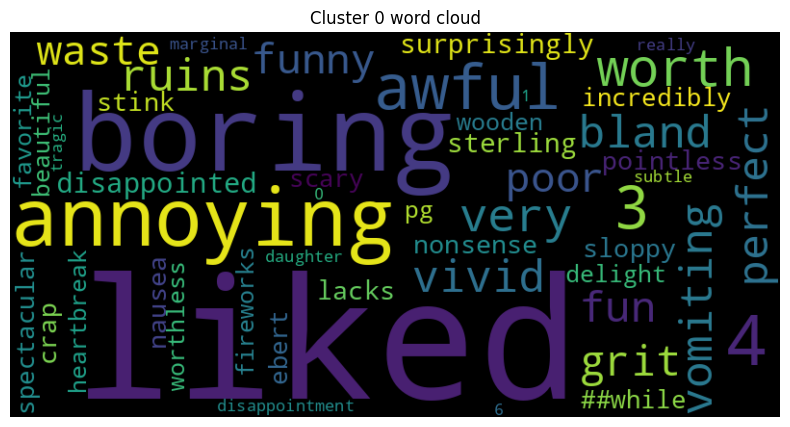

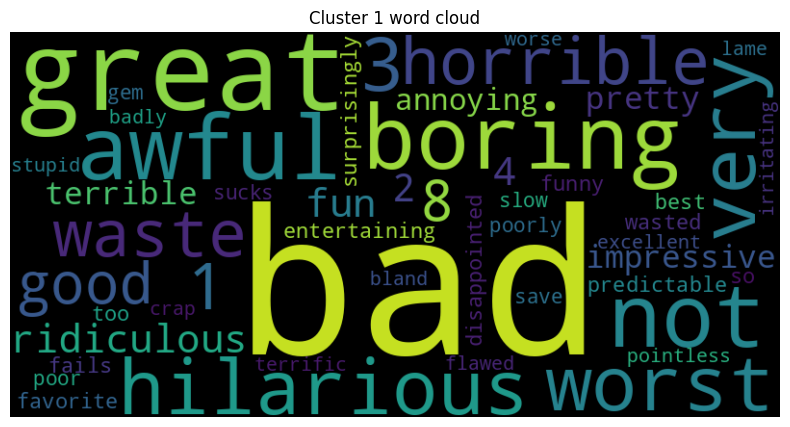

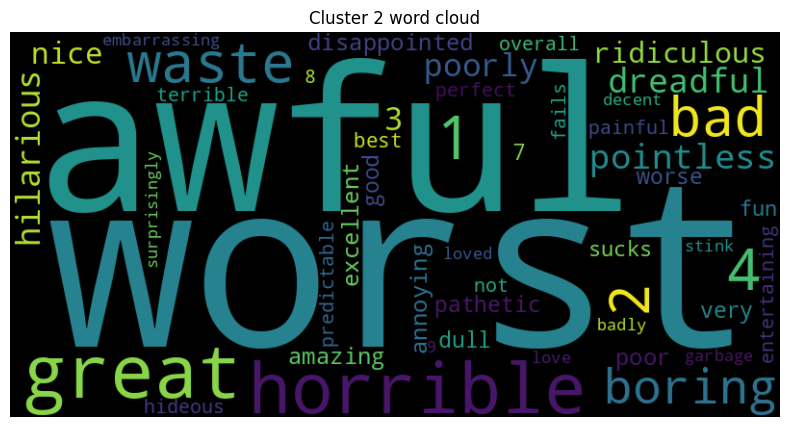

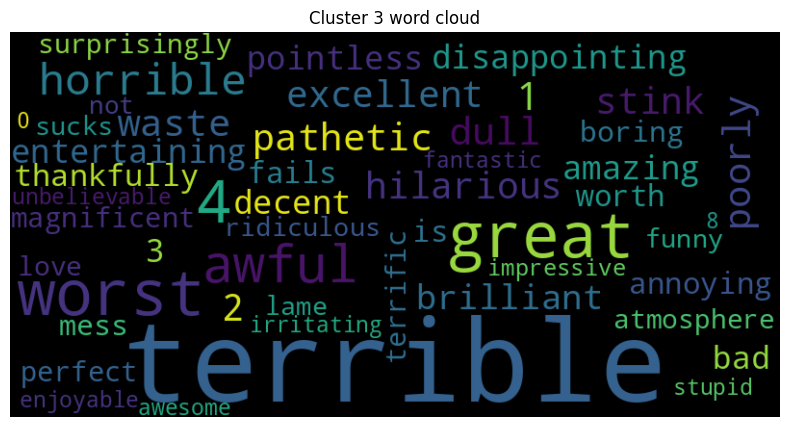

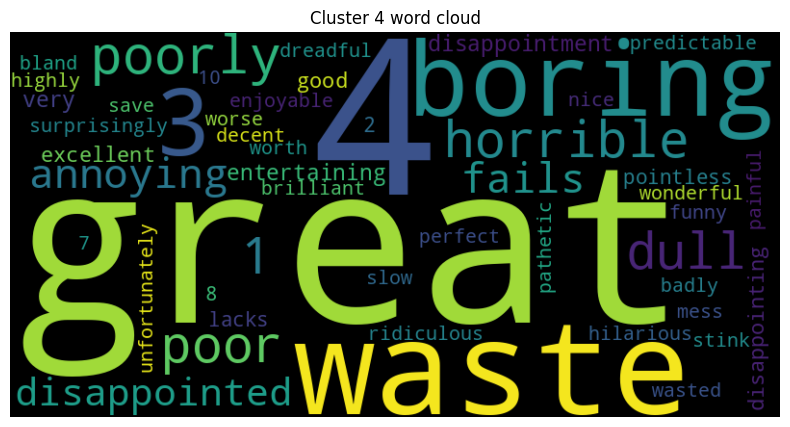

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def cluster_wordcloud(R_vocab, cluster_ids, tokenizer, cluster_id, max_words=50):
    idxs = [i for i, c in enumerate(cluster_ids) if c == cluster_id]
    cluster_matrix = R_vocab[idxs]
    mean_sal = cluster_matrix.mean(axis=0)

    # build {token: weight} dict
    token_weights = {}
    for tok_id, w in enumerate(mean_sal):
        if w <= 0:
            continue
        tok = tokenizer.convert_ids_to_tokens([tok_id])[0]
        if tok in tokenizer.all_special_tokens:
            continue
        if tok.strip() == "":
            continue
        token_weights[tok] = float(w)

    wc = WordCloud(width=800, height=400, max_words=max_words)
    wc.generate_from_frequencies(token_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} word cloud")
    plt.show()
n_clusters = 5
# Example: visualize all clusters
for c in range(n_clusters):
    cluster_wordcloud(R_vocab, cluster_ids, tokenizer, cluster_id=c)


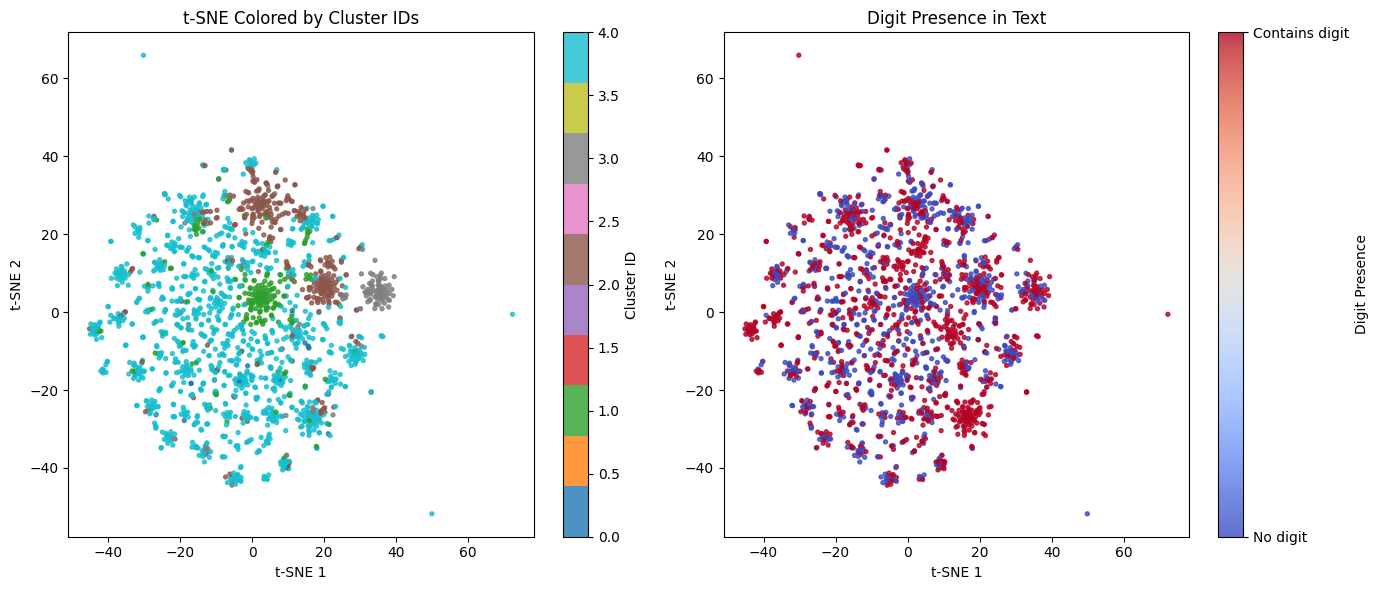

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def plot_tsne_combined(R_vocab, texts, cluster_ids, sample_size=2000):
    n = min(sample_size, R_vocab.shape[0])
    R_sub = R_vocab[:n]
    texts_sub = texts[:n]
    cluster_sub = cluster_ids[:n]

    tsne = TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        perplexity=30,
        random_state=0,
    )
    coords = tsne.fit_transform(R_sub)

    has_digit = np.array([int(any(ch.isdigit() for ch in t)) for t in texts_sub])

    plt.figure(figsize=(14, 6))

    # --------------------------
    # Left plot: clusters
    # --------------------------
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(
        coords[:, 0],
        coords[:, 1],
        c=cluster_sub,
        s=8,
        cmap="tab10",
        alpha=0.8,
    )
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("t-SNE Colored by Cluster IDs")
    plt.colorbar(scatter1, label="Cluster ID")

    # --------------------------
    # Right plot: digit presence
    # --------------------------
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(
        coords[:, 0],
        coords[:, 1],
        c=has_digit,
        s=8,
        cmap="coolwarm",
        alpha=0.8,
        vmin=0,
        vmax=1,
    )
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("Digit Presence in Text")

    # Add legend describing color meaning
    cbar = plt.colorbar(scatter2, ticks=[0, 1])
    cbar.ax.set_yticklabels(["No digit", "Contains digit"])
    cbar.set_label("Digit Presence")

    plt.tight_layout()
    plt.show()

plot_tsne_combined(R_vocab, texts_neg, cluster_ids, sample_size=2000)

Measure how many numeric-rating texts appear inside a specific cluster.

In [24]:
import re

rating_pattern = re.compile(r"\b\d+\s*/\s*10\b|\b\d+\s*star[s]?\b|\brating\b", re.IGNORECASE)

def is_numeric_example(text):
    return bool(rating_pattern.search(text))

labels_numeric = np.array([is_numeric_example(t) for t in texts_neg])

# identify numeric cluster: the one whose top tokens are mostly digits
for id in range(0,5):
    numeric_cluster_id = id  # adjust after looking at describe_clusters

    cluster_mask = (np.array(cluster_ids) == numeric_cluster_id)
    
    # Precision: Of the examples in this cluster, how many contain numeric ratings?
    precision = labels_numeric[cluster_mask].mean() if cluster_mask.any() else 0.0

    # Recall Of all numeric-rating examples, how many are in this cluster?
    recall = (labels_numeric[cluster_mask].sum() / labels_numeric.sum()) if labels_numeric.sum() > 0 else 0.0

    print(f"Numeric cluster {numeric_cluster_id}: precision={precision:.2f}, recall={recall:.2f}")


Numeric cluster 0: precision=0.21, recall=0.02
Numeric cluster 1: precision=0.07, recall=0.07
Numeric cluster 2: precision=0.13, recall=0.22
Numeric cluster 3: precision=0.12, recall=0.07
Numeric cluster 4: precision=0.10, recall=0.61


In [46]:
# select indices of negatively predicted examples
pos_indices = [i for i, p in enumerate(test_preds) if p == 1]  
len(pos_indices)

# sample 2500 of them (or fewer if you have less)
np.random.seed(0)
sample_size = min(2500, len(pos_indices))
pos_indices_samples = np.random.choice(pos_indices, size=sample_size, replace=False)

R_vocab_pos, texts_pos = build_salience_vocab_matrix_from_indices(
    test_data,
    pos_indices_samples,
    model,
    tokenizer,
    device,
    top_k=5,
)

100%|██████████| 2500/2500 [02:21<00:00, 17.65it/s]


In [47]:
cluster_ids_pos, kmeans_pos = cluster_salience(R_vocab_pos, n_clusters=5)

In [48]:
describe_clusters(R_vocab_pos, cluster_ids_pos, tokenizer, top_m_terms=5)

Cluster 0
  Size: 15 (0.60% of sample)
  Top terms: thin, asleep, waste, sad, wasted
------------------------------------------------------------
Cluster 1
  Size: 128 (5.12% of sample)
  Top terms: bad, too, 7, not, very
------------------------------------------------------------
Cluster 2
  Size: 209 (8.36% of sample)
  Top terms: excellent, superb, 8
------------------------------------------------------------
Cluster 3
  Size: 45 (1.80% of sample)
  Top terms: hilarious, annoying, recommend
------------------------------------------------------------
Cluster 4
  Size: 2103 (84.12% of sample)
  Top terms: wonderful, 7, great, 8
------------------------------------------------------------


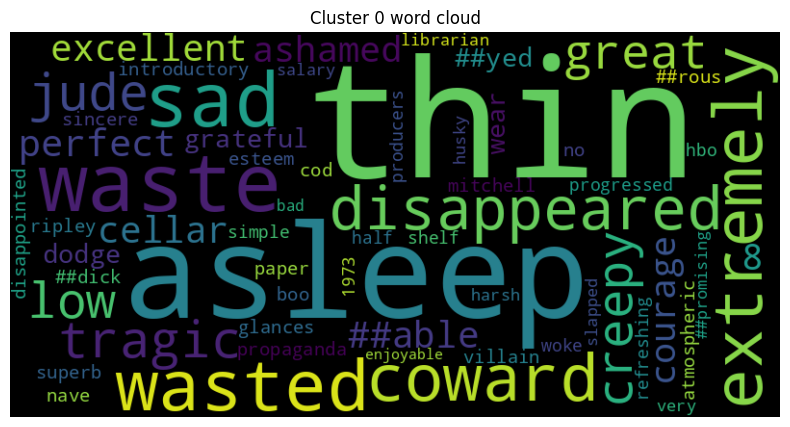

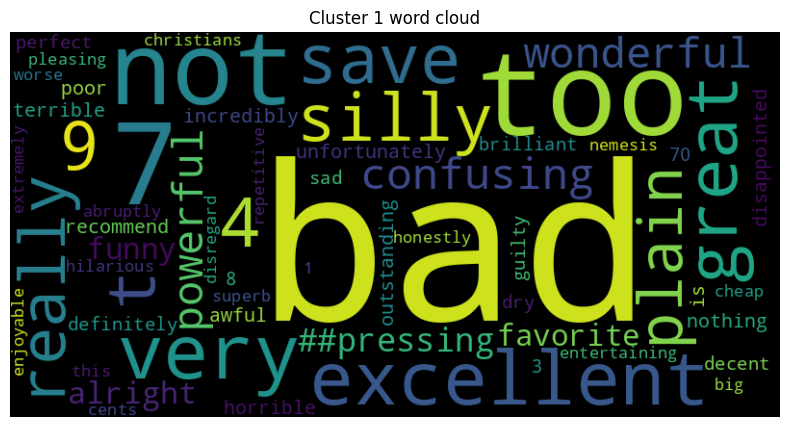

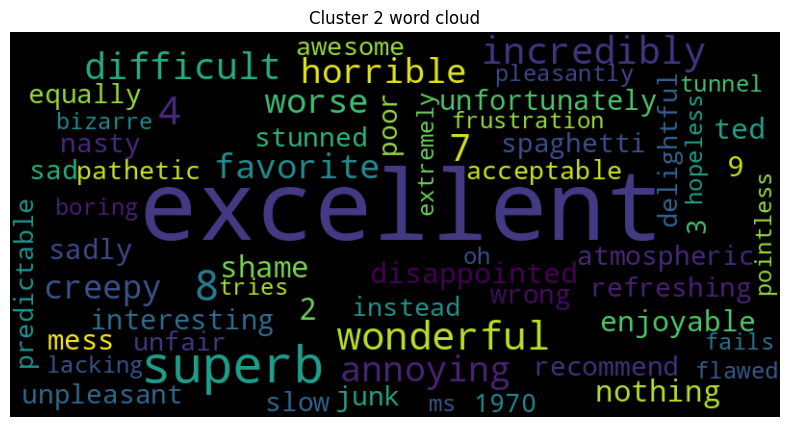

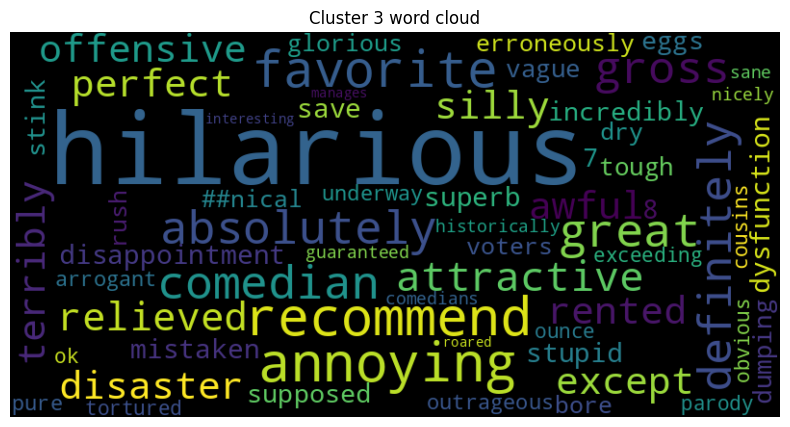

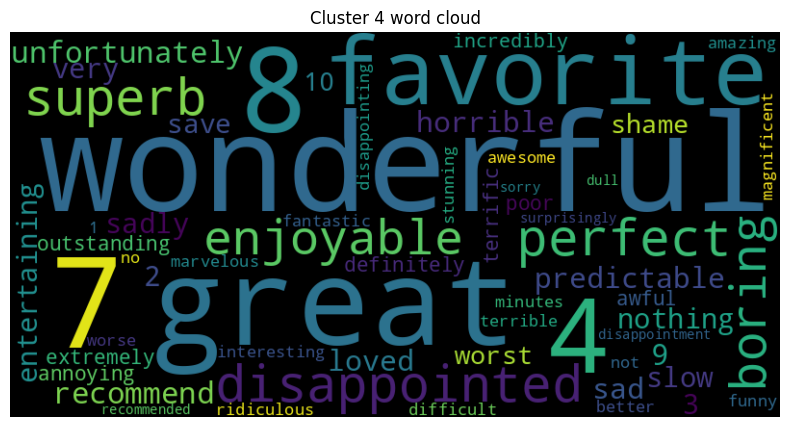

In [49]:
n_clusters = 5
# Example: visualize all clusters
for c in range(n_clusters):
    cluster_wordcloud(R_vocab_pos, cluster_ids_pos, tokenizer, cluster_id=c)

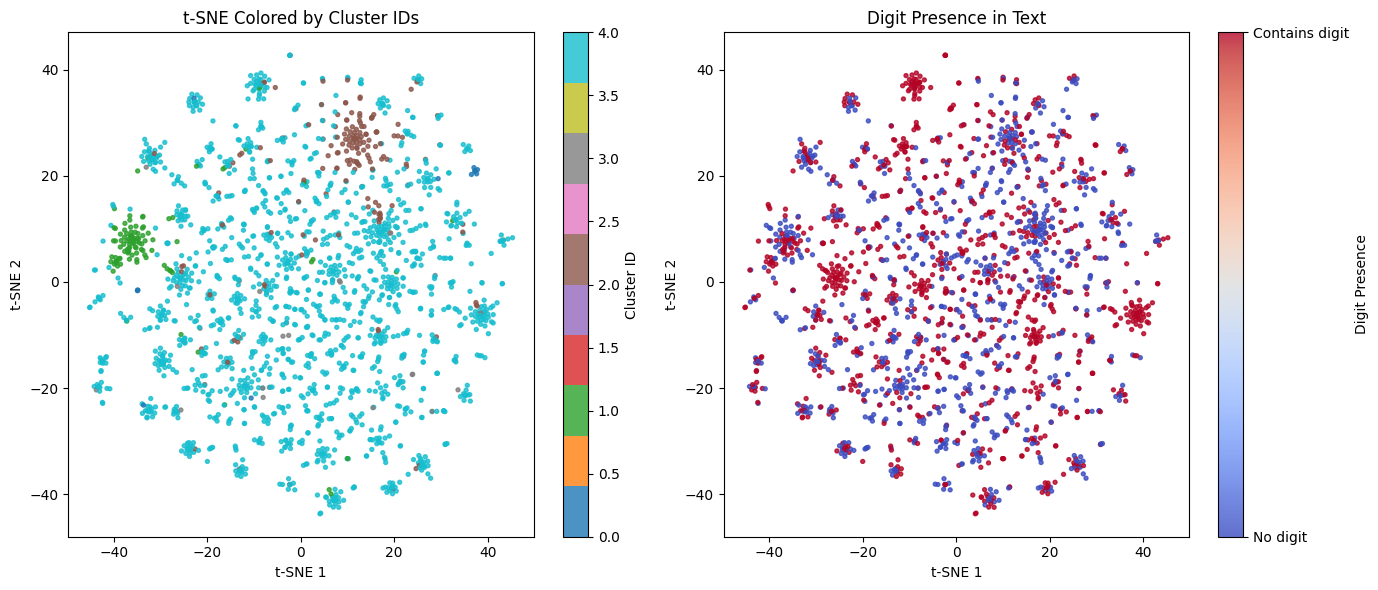

In [50]:
plot_tsne_combined(R_vocab_pos, texts_pos, cluster_ids_pos, sample_size=2000)

In [41]:
import numpy as np
import torch

def build_R_emb_from_R_vocab(R_vocab, model, normalize=True):
    """
    Implements S2 from the paper:
        R_emb = R_vocab @ E
    where E is the BERT word embedding matrix.

    Args:
        R_vocab : np.ndarray, shape [N, |V|]
        model   : fine-tuned BertForSequenceClassification
        normalize : whether to L2-normalize rows to unit length

    Returns:
        R_emb : np.ndarray, shape [N, d]
    """
    # Get embedding matrix E (|V| x d) from the model
    with torch.no_grad():
        E = model.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()

    # Matrix multiplication in numpy: [N, |V|] @ [|V|, d] -> [N, d]
    R_emb = R_vocab @ E

    if normalize:
        norms = np.linalg.norm(R_emb, axis=1, keepdims=True) + 1e-12
        R_emb = R_emb / norms

    return R_emb


In [42]:
R_emb = build_R_emb_from_R_vocab(R_vocab, model)
R_emb.shape   # -> (N, d) e.g. (2500, 768)


(2500, 768)

In [43]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans_emb = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_ids_emb = kmeans_emb.fit_predict(R_emb)
np.bincount(cluster_ids_emb)


array([ 357, 1276,  135,  370,  362])

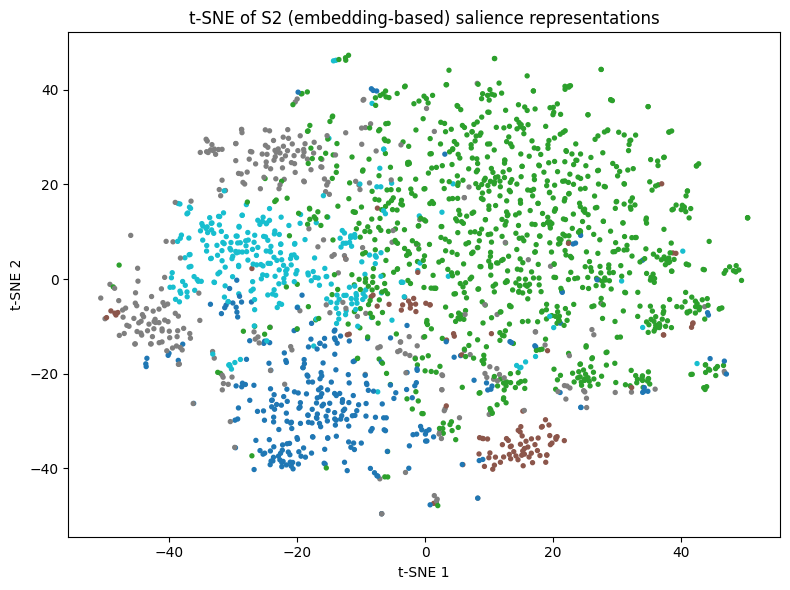

In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_S2(R_emb, cluster_ids, sample_size=2000):
    n = min(sample_size, R_emb.shape[0])
    R_sub = R_emb[:n]
    c_sub = cluster_ids[:n]

    tsne = TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        perplexity=30,
        random_state=0,
    )
    coords = tsne.fit_transform(R_sub)

    plt.figure(figsize=(8, 6))
    plt.scatter(coords[:, 0], coords[:, 1], c=c_sub, s=8, cmap="tab10")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title("t-SNE of S2 (embedding-based) salience representations")
    plt.tight_layout()
    plt.show()

plot_tsne_S2(R_emb, cluster_ids_emb)
